#### Подготовка данных

Изначальный датасет довольно избыточный, поэтому для проведения задания мы пользуемся этим ноутбуком, чтобы взять только нужную часть

Скачать весь датасет (~5 Гб) можно по этой ссылке: https://drive.google.com/file/d/1CUZnBtYwifVXS21yVg62T-vrPVayso5H/view

Файл с отсутствующими скелетами можно скачать из репозитория либо с google диска wget: https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt

In [2]:
!gdown 'https://drive.google.com/uc?export=dowloa&id=1CUZnBtYwifVXS21yVg62T-vrPVayso5H'

Downloading...
From: https://drive.google.com/uc?export=dowloa&id=1CUZnBtYwifVXS21yVg62T-vrPVayso5H
To: /content/nturgbd_skeletons_s001_to_s017.zip
6.18GB [02:04, 49.7MB/s]


In [3]:
!unzip /content/nturgbd_skeletons_s001_to_s017.zip

Streaming output truncated to the last 5000 lines.
  inflating: nturgb+d_skeletons/S004C002P003R002A043.skeleton  
  inflating: nturgb+d_skeletons/S011C001P025R002A017.skeleton  
  inflating: nturgb+d_skeletons/S006C001P008R002A022.skeleton  
  inflating: nturgb+d_skeletons/S007C001P019R001A001.skeleton  
  inflating: nturgb+d_skeletons/S015C001P016R002A037.skeleton  
  inflating: nturgb+d_skeletons/S007C001P019R002A005.skeleton  
  inflating: nturgb+d_skeletons/S008C002P007R002A058.skeleton  
  inflating: nturgb+d_skeletons/S002C001P010R002A012.skeleton  
  inflating: nturgb+d_skeletons/S006C003P008R002A019.skeleton  
  inflating: nturgb+d_skeletons/S014C003P039R002A013.skeleton  
  inflating: nturgb+d_skeletons/S016C001P008R002A030.skeleton  
  inflating: nturgb+d_skeletons/S004C001P003R002A035.skeleton  
  inflating: nturgb+d_skeletons/S009C003P008R001A049.skeleton  
  inflating: nturgb+d_skeletons/S014C001P015R002A008.skeleton  
  inflating: nturgb+d_skeletons/S006C002P001R001A005.

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g' -O NTU_RGBD_samples_with_missing_skeletons.txt

--2021-07-11 08:25:30--  https://drive.google.com/uc?export=download&id=1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g
Resolving drive.google.com (drive.google.com)... 108.177.13.101, 108.177.13.138, 108.177.13.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.13.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hp367jps4kcmqiecct5l7oh2tp8mrt6n/1625991900000/14904333240138417226/*/1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g?e=download [following]
--2021-07-11 08:25:31--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hp367jps4kcmqiecct5l7oh2tp8mrt6n/1625991900000/14904333240138417226/*/1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-0

In [16]:
data_path = "/content/nturgb+d_skeletons/"
# список отсутсвующих элементов
broken_files_path = "/content/NTU_RGBD_samples_with_missing_skeletons.txt"

In [27]:
training_classes = [8, 10, 22, 23, 27] # классы которые будем использовать 
# для обучения, полный список представлен тут https://github.com/shahroudy/NTURGB-D

training_cameras = [1, 2, 3] 

amount_of_samples = 120
num_joint = 25
max_frame = 45  # Длина отрезка которую мы достаем из датасета

Есть функция, которая позволяет нам считать данные для каждого класса. 

In [28]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            
            if action_class in training_classes and camera_id in training_cameras:
                if action_class in action_classes:
                    if files_counter[action_class] < amount_of_samples:
                        files.append([filename, action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter += 1
                    files.append([filename, action_classes[action_class]])

    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [29]:
# Функция фильтр для того, что бы найти только координаты x, y, z (т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []

        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

    return data

**В этой функции меняем количество фреймов подаваемых на вход модели**

В задании нужно пронаблюдать зависимость качества обучения модели от количества кадров, которые мы подаем в модель. Т.е. то, cколько кадров у нас отведено на один блок.

По хорошему функцию ниже нужно прописать внутри определения датасета.

In [30]:
def create_coords_blocks(data, chunk_len=45):   
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + data[0])[0]
    label = data[1]
    slice_len = chunk_len * int(len(test_frames)/chunk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chunk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [31]:
# список файлов с лейблами на каждый файл 
import os
import numpy as np
import pandas as pd


working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {10: 0, 27: 1, 8: 2, 23: 3, 22: 4}
action files:  {10: 120, 27: 120, 8: 120, 23: 120, 22: 120}


In [32]:
LABELS = {v: k for k, v in action_classes.items()}

Здесь выносится сгенерированный список лейблов с номером класса.

In [33]:
LABELS

{0: 10, 1: 27, 2: 8, 3: 23, 4: 22}

In [34]:
working_files_with_labels[:10]

[['S014C003P037R001A010.skeleton', 0],
 ['S002C003P014R002A027.skeleton', 1],
 ['S002C003P013R002A010.skeleton', 0],
 ['S004C003P007R002A027.skeleton', 1],
 ['S016C001P008R001A008.skeleton', 2],
 ['S011C001P015R001A023.skeleton', 3],
 ['S006C001P017R002A010.skeleton', 0],
 ['S006C001P017R001A027.skeleton', 1],
 ['S011C002P017R002A023.skeleton', 3],
 ['S011C003P002R002A010.skeleton', 0]]

In [35]:
len(working_files_with_labels)

600

In [36]:
data = []
labels = []
numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0}
for file_label in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file_label, chunk_len=max_frame)
    
    if label != [] and numbers[label[0]] < amount_of_samples:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label


data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

In [37]:
numbers

{0: 120, 1: 119, 2: 121, 3: 120, 4: 121}

In [38]:
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,0.275517,0.186158,3.222958,0.280147,0.457213,3.101250,0.282616,0.720651,2.967922,0.283662,0.844001,2.914359,0.119973,0.646744,3.036438,0.073812,0.395607,3.185686,0.067326,0.158099,3.216287,0.074535,0.111265,3.225045,0.432985,0.620972,2.982954,0.477588,0.388015,3.112100,0.475409,0.153330,3.156705,0.456520,0.084503,3.174868,0.203091,0.186469,3.198362,0.185211,...,0.180864,0.207559,3.193405,0.176943,-0.063145,3.378575,0.218227,-0.392947,3.630840,0.200058,-0.477302,3.525618,0.319758,0.201118,3.176285,0.354153,-0.039060,3.330093,0.374709,-0.370479,3.599668,0.355075,-0.455022,3.494546,0.262301,0.676211,3.040546,0.261278,0.480910,2.765009,0.180373,0.469067,2.779429,0.212831,0.512033,2.775434,0.177846,0.510785,2.816400,0
1,-0.004526,-0.175548,2.215058,-0.028734,0.121439,2.133477,-0.052261,0.409418,2.038800,-0.007190,0.532708,2.021808,-0.115977,0.252168,1.944053,-0.159987,-0.015906,1.934789,-0.132598,-0.233802,1.968011,-0.125931,-0.320952,2.009123,0.025784,0.348484,2.219508,0.072821,0.072298,2.298596,0.119954,-0.196084,2.392605,0.092663,-0.238535,2.441146,-0.039385,-0.183846,2.130898,-0.109297,...,0.141999,-0.297431,2.253459,0.090800,-0.604119,2.195507,0.039620,-0.944184,2.437657,0.080756,-1.013502,2.319471,0.265996,-0.308748,2.290308,0.335275,-0.602707,2.300781,0.340191,-0.871241,2.525103,0.377552,-0.941835,2.406735,0.207729,0.185870,2.116532,0.305834,-0.306941,2.034351,0.260979,-0.239480,2.123250,0.470418,-0.371376,2.061867,0.489695,-0.346997,2.076800,1
2,0.191725,-0.153002,2.443842,0.164345,0.156142,2.345756,0.136644,0.456149,2.233690,0.163906,0.598793,2.238869,0.053477,0.285701,2.169456,0.023604,-0.003011,2.182116,0.090710,-0.225992,2.232216,0.095461,-0.283403,2.259230,0.246900,0.367470,2.392718,0.244604,0.139314,2.545225,0.275276,-0.082487,2.622536,0.289514,-0.148482,2.625006,0.140035,-0.168809,2.355499,0.079719,...,0.159254,-0.162946,2.369927,0.099250,-0.509276,2.463089,0.034840,-0.863637,2.599528,0.083642,-0.919749,2.619316,0.250401,-0.139513,2.492034,0.243922,-0.481786,2.628615,0.159393,-0.826762,2.741936,0.241131,-0.879760,2.655466,0.148231,0.387923,2.291709,0.483187,0.275048,2.240508,0.411676,0.293293,2.149060,0.189198,0.448772,2.256771,0.175406,0.349551,2.214528,0
3,0.287666,0.321616,3.037616,0.251930,0.613913,2.995818,0.218704,0.901252,2.940862,0.287713,1.029270,2.949162,0.174681,0.722186,2.827404,0.102303,0.420783,2.807971,0.131105,0.182731,2.815117,0.137220,0.174664,2.829443,0.391821,0.813048,3.075732,0.245050,0.626100,2.836052,0.109285,0.330194,2.811334,0.118400,0.260662,2.813671,0.234930,0.305344,2.980112,0.189168,...,0.250384,0.106666,2.787000,0.417374,-0.240346,2.895365,0.236280,-0.546420,2.963368,0.320537,-0.612442,2.867100,0.338197,0.114196,2.883406,0.451064,-0.065395,3.146515,0.255490,0.178178,2.963331,0.291007,0.034353,2.911430,0.379453,0.630730,2.758332,0.430488,-0.025426,2.781713,0.491090,0.057415,2.733445,0.541313,-0.019890,3.090768,0.514215,-0.015494,3.054500,1
4,0.211629,0.024165,3.775199,0.211908,0.272136,3.678800,0.212368,0.515305,3.571388,0.184967,0.639374,3.517854,0.079718,0.432394,3.690752,0.056970,0.260941,3.823523,0.034187,0.057521,3.870193,0.032739,0.004532,3.881945,0.327911,0.391684,3.527585,0.360202,0.174253,3.584018,0.328399,-0.016102,3.634349,0.296411,-0.081218,3.666608,0.149878,0.025197,3.778607,0.125152,...,0.234620,-0.176558,4.336957,0.069145,-0.210162,4.067904,0.141186,-0.480787,4.268869,0.106348,-0.552256,4.257716,0.364090,-0.186604,4.336705,0.396045,-0.292495,4.037478,0.376894,-0.568530,4.138502,0.333453,-0.629665,4.143112,0.306783,0.115189,3.940619,0.017277,-0.138864,4.309893,0.004117,-0.065546,4.277333,0.403378,-0.113503,4.041338,0.462458,-0.078173,3.933500,2
...,...,...,...,.

**Ваш итоговый файл**

In [39]:
test_data.to_csv("new_skels.csv", index=False)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [42]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_layer, layer_num):
        super().__init__()
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_layer, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_layer, output_layer)
        
    def forward(self, inputs):
        lstm_out, (hn, cn) = self.lstm(inputs)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [43]:
from torch.utils.data import DataLoader, Dataset

In [44]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [45]:
dataset = Skeleton_Dataset(file_path = "new_skels.csv", transform=None)

In [49]:
skeleton, label = dataset[41]
label, skeleton

(2, array([[-0.0801414 ,  0.1350729 ,  3.691227  , ...,  0.07300865,
          0.02810352,  3.50405   ],
        [-0.0808364 ,  0.1344202 ,  3.690399  , ...,  0.06993203,
          0.03089946,  3.50029   ],
        [-0.08067498,  0.1341641 ,  3.68989   , ...,  0.06890631,
          0.06125712,  3.486714  ],
        ...,
        [ 0.1704498 , -0.08206525,  3.991596  , ...,  0.1386959 ,
         -0.1721927 ,  3.714556  ],
        [ 0.1702198 , -0.08385049,  3.994602  , ...,  0.1260822 ,
         -0.1696543 ,  3.711588  ],
        [ 0.1801723 , -0.0811804 ,  4.002936  , ...,  0.180819  ,
         -0.1304248 ,  3.7243    ]]))

In [52]:
LABELS[label], skeleton.shape

(8, (45, 75))

In [53]:
train_shape = 0.7
train_len = int(train_shape * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [55]:
input_layer = 25 * 3
hidden_layer = 128
output_layer = len(LABELS)
layer_num = 2
model = LSTM(input_layer, hidden_layer, output_layer, layer_num)
model.to(device)

LSTM(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [57]:
def get_target_from_output(output):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()

    return LABELS[category_i], category_i

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
from torch import optim
import time
import math

learning_rate = 0.001
momentum = 0.95

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)

losses = []
start = time.time()
counter = 0

for epoch in range(600):  
    loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
  
        output = model(inputs.float())

        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step() 

        loss += loss.item()

        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = get_target_from_output(output)
            
            correct = '✓' if guess == category else '✗ (%s)' % category

            print('Epoch %d iteration: %d (%s) %.4f  / %s %s' % (epoch, i, time_since(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        losses.append(loss / 25)
        loss = 0

Epoch 0 iteration: 0 (0m 0s) 0.5397  / 22 ✓
Epoch 18 iteration: 14 (0m 37s) 0.6991  / 22 ✓
Epoch 37 iteration: 1 (1m 14s) 2.7760  / 23 ✓
Epoch 55 iteration: 15 (1m 49s) 0.6763  / 27 ✗ (10)
Epoch 74 iteration: 2 (2m 26s) 0.3377  / 23 ✓
Epoch 92 iteration: 16 (3m 2s) 1.2013  / 8 ✗ (10)
Epoch 111 iteration: 3 (3m 38s) 0.6337  / 22 ✓
Epoch 129 iteration: 17 (4m 14s) 1.0456  / 10 ✓
Epoch 148 iteration: 4 (4m 51s) 0.4353  / 8 ✓
Epoch 166 iteration: 18 (5m 27s) 0.3084  / 27 ✓
Epoch 185 iteration: 5 (6m 3s) 0.1318  / 10 ✓
Epoch 203 iteration: 19 (6m 40s) 0.1221  / 8 ✓
Epoch 222 iteration: 6 (7m 18s) 0.1577  / 10 ✓
Epoch 240 iteration: 20 (7m 56s) 0.2677  / 8 ✓
Epoch 259 iteration: 7 (8m 34s) 0.2759  / 22 ✓
Epoch 277 iteration: 21 (9m 12s) 0.0166  / 23 ✓
Epoch 296 iteration: 8 (9m 50s) 0.0040  / 22 ✓
Epoch 314 iteration: 22 (10m 29s) 0.0281  / 23 ✓
Epoch 333 iteration: 9 (11m 8s) 0.3508  / 10 ✓
Epoch 351 iteration: 23 (11m 47s) 0.0050  / 10 ✓
Epoch 370 iteration: 10 (12m 25s) 0.1098  / 27 ✓
Epo

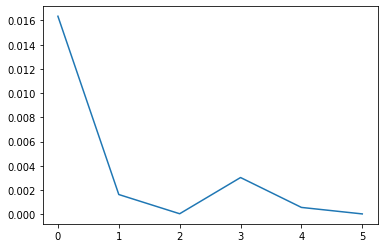

In [66]:
losses_number = len(losses)

plt.plot(
    list(range(0, losses_number)),
    losses
)

plt.show()